# Recommendation Model Training

Training Item-Based Collaborative Filtering model for e-commerce recommendation system.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.metrics.pairwise import cosine_similarity
import warnings

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

## Load Data

In [2]:
# Database connection
DB_CONFIG = {
    'host': 'localhost',
    'port': 3306,
    'database': 'ecommerce_db',
    'user': 'root',
    'password': 'root'
}

connection_string = f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
engine = create_engine(connection_string)

In [3]:
# Load user-product interactions
query_views = """
SELECT 
    user_id,
    product_id,
    view_count,
    last_viewed_at
FROM user_product_views
"""
df_interactions = pd.read_sql(query_views, engine)

print(f"Loaded {len(df_interactions):,} interactions")
print(f"Users: {df_interactions['user_id'].nunique()}")
print(f"Products: {df_interactions['product_id'].nunique()}")

df_interactions.head()

Loaded 8,428 interactions
Users: 227
Products: 200


,user_id,product_id,view_count,last_viewed_at
0,b'/\x18\xd3(\xc9\x06L\x85\xa4\x15\x98\xf7\x1c\...,b'\x00M\x14.\x8d\x8eG\xc9\xb8\x1eI\x16\x8b\xd3...,2,2025-12-14 23:10:25.692646
1,b';md\xe4b E\xa4\x9b\xadm\xae{\xf0\x1f\x03',b'\x00M\x14.\x8d\x8eG\xc9\xb8\x1eI\x16\x8b\xd3...,1,2025-12-13 14:29:41.693740
2,b'Y\x07\xad\xe6\xf5\rG1\x84\x1d]$l6\x90\x06',b'\x00M\x14.\x8d\x8eG\xc9\xb8\x1eI\x16\x8b\xd3...,1,2025-11-11 06:07:01.695165
3,b'[\x80\x8f\xb4k\xd5Ey\xa3jn\xf8\x0cO\xab.',b'\x00M\x14.\x8d\x8eG\xc9\xb8\x1eI\x16\x8b\xd3...,1,2025-11-26 15:04:27.696164
4,b'y\xfd\xe2^\xe7\xe2D\xcf\xa1\xa4\x93\xcb\x13T...,b'\x00M\x14.\x8d\x8eG\xc9\xb8\x1eI\x16\x8b\xd3...,1,2025-11-16 13:56:02.697165


In [4]:
# Load product information
query_products = """
SELECT 
    p.id as product_id,
    p.name as product_name,
    c.name as category_name
FROM products p
LEFT JOIN categories c ON p.category_id = c.id
"""
df_products = pd.read_sql(query_products, engine)

print(f"Loaded {len(df_products):,} products")

Loaded 200 products


## Train/Test Split

Using time-based split (80/20) to simulate real-world scenario.

In [5]:
# Time-based split
split_date = df_interactions['last_viewed_at'].quantile(0.8)
train_data = df_interactions[df_interactions['last_viewed_at'] <= split_date].copy()
test_data = df_interactions[df_interactions['last_viewed_at'] > split_date].copy()

print(f"Split date: {split_date}")
print(f"Training: {len(train_data):,} ({len(train_data)/len(df_interactions)*100:.1f}%)")
print(f"Testing: {len(test_data):,} ({len(test_data)/len(df_interactions)*100:.1f}%)")

Split date: 2025-12-13 15:11:08.298765568
Training: 6,742 (80.0%)
Testing: 1,686 (20.0%)


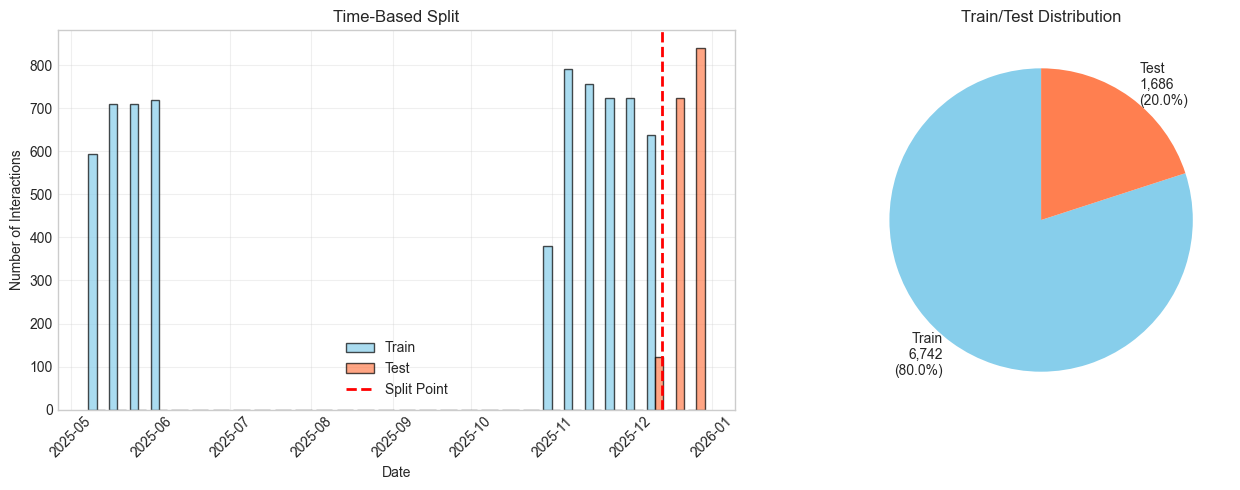

In [6]:
# Visualize split
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Timeline
train_dates = pd.to_datetime(train_data['last_viewed_at']).dt.date
test_dates = pd.to_datetime(test_data['last_viewed_at']).dt.date

axes[0].hist([train_dates, test_dates], bins=30, label=['Train', 'Test'], 
             color=['skyblue', 'coral'], alpha=0.7, edgecolor='black')
axes[0].axvline(pd.to_datetime(split_date).date(), color='red', linestyle='--', linewidth=2, label='Split Point')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Interactions')
axes[0].set_title('Time-Based Split')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Distribution
sizes = [len(train_data), len(test_data)]
labels = [f'Train\n{len(train_data):,}\n({len(train_data)/len(df_interactions)*100:.1f}%)',
          f'Test\n{len(test_data):,}\n({len(test_data)/len(df_interactions)*100:.1f}%)']
colors = ['skyblue', 'coral']
axes[1].pie(sizes, labels=labels, autopct='', startangle=90, colors=colors)
axes[1].set_title('Train/Test Distribution')

plt.tight_layout()
plt.show()

## Build User-Item Matrix

In [7]:
# Create user-item matrix
user_item_matrix = train_data.pivot_table(
    index='user_id',
    columns='product_id',
    values='view_count',
    fill_value=0
)

print(f"Matrix shape: {user_item_matrix.shape[0]} users x {user_item_matrix.shape[1]} products")
print(f"Total cells: {user_item_matrix.shape[0] * user_item_matrix.shape[1]:,}")
print(f"Non-zero cells: {(user_item_matrix > 0).sum().sum():,}")
print(f"Sparsity: {(user_item_matrix == 0).sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100:.2f}%")

user_item_matrix.head()

Matrix shape: 227 users x 200 products
Total cells: 45,400
Non-zero cells: 6,742
Sparsity: 85.15%


product_id,b'\x00M\x14.\x8d\x8eG\xc9\xb8\x1eI\x16\x8b\xd3\xf8\x8b',b'\x04\x08\x14\x18\xef\xaeJj\x9aR\xe7h\x9c2g!',b'\x06\xc1|\xed#uB\x8d\x94\xd7X\xf5]\x12\xe7\xab',"b""\x08'\x9d\xa9\x9e;K\xb0\x8b\xed\xd8l\x125\xe4\xec""",b'\x08@\xe7\x07\xed\xfcL1\xaaP\x97\xd0\xf0\x04\xa8\xce',b'\x08\xbbM\xb6\xea\xadGh\xb9\xb16*C\xdff{',"b""\t\x7f3\xa0\xb95OB\x8a\xc2~'\x16\xb8\xc0\xb5""",b'\n\x14\xd3\x96\xfe\x03J7\xbbT\xe9!\x1a=m\xac',b'\x0c\x89u6\x1f\x9cK\xbf\x99\x89\xf2\xb2\xd1\x8d\x93L',b'\x0e?\x97p\x15}D\x0c\xaf\xff\xf4+\xddH\r\xbf',...,b'\xf5@|\x8e\x12\x13L\xa3\x8d>\xf1\xd8D\x83\x81]',b'\xf5[V\xe0q|C\xb7\xa2n\xae\xaej\xedq\xaa',b'\xf5r=&y@H\x8b\xba\xf0\xa7u\r\xf5/P',"b""\xf7\x0bQL`\xa7K'\xb5\xfd\x93\xa8\xef\ro\x94""",b'\xf7_\xf7q\x86`E\xe9\x90\xd9#\xb4\t\xee\xea\x99',"b'\xf8\xee\\b\x8d\x8fC""\x93^y\x7f\xc5\xdb\xff7'",b'\xfc\x1a|\xd9\xbbZC%\x9a5\xb8\x01\xb3\xbdg\xa6',b'\xfcs\x98s\xe5\x8aH\xf1\xa0\xb2\xca\x9e\xa2\xe6z\xca',b'\xfc\xd7e\xc0g\\I\x84\x830\x80\x91\xccd#Q',"b'\xfe\xb2\xc8f3\xe3GZ\x98\xac""=\xabW`\x15'"
user_id,,,,,,,,,,,,,,,,,,,,,
b'\x00\x86\\Q\xdf\xa0E\xa7\xadOQ\x0e6l\xcf\xcb',0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0
b'\x00\x92]\x0e\n;Of\x8a\xc6R\x1cE%U^',0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0
b'\x03\xee#\x97\x0eVI\xf6\x80\xe8\x01\x7f\xb8\x05\xb3\x00',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
b'\x05J\xf8\x89\xbc^J\xae\x94|\n\xc1$\x80:\xe8',0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0
b'\x05\xbdI\xb0\x8b6DG\xaac\xc6\x7f\xa0-\x8f\xb1',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


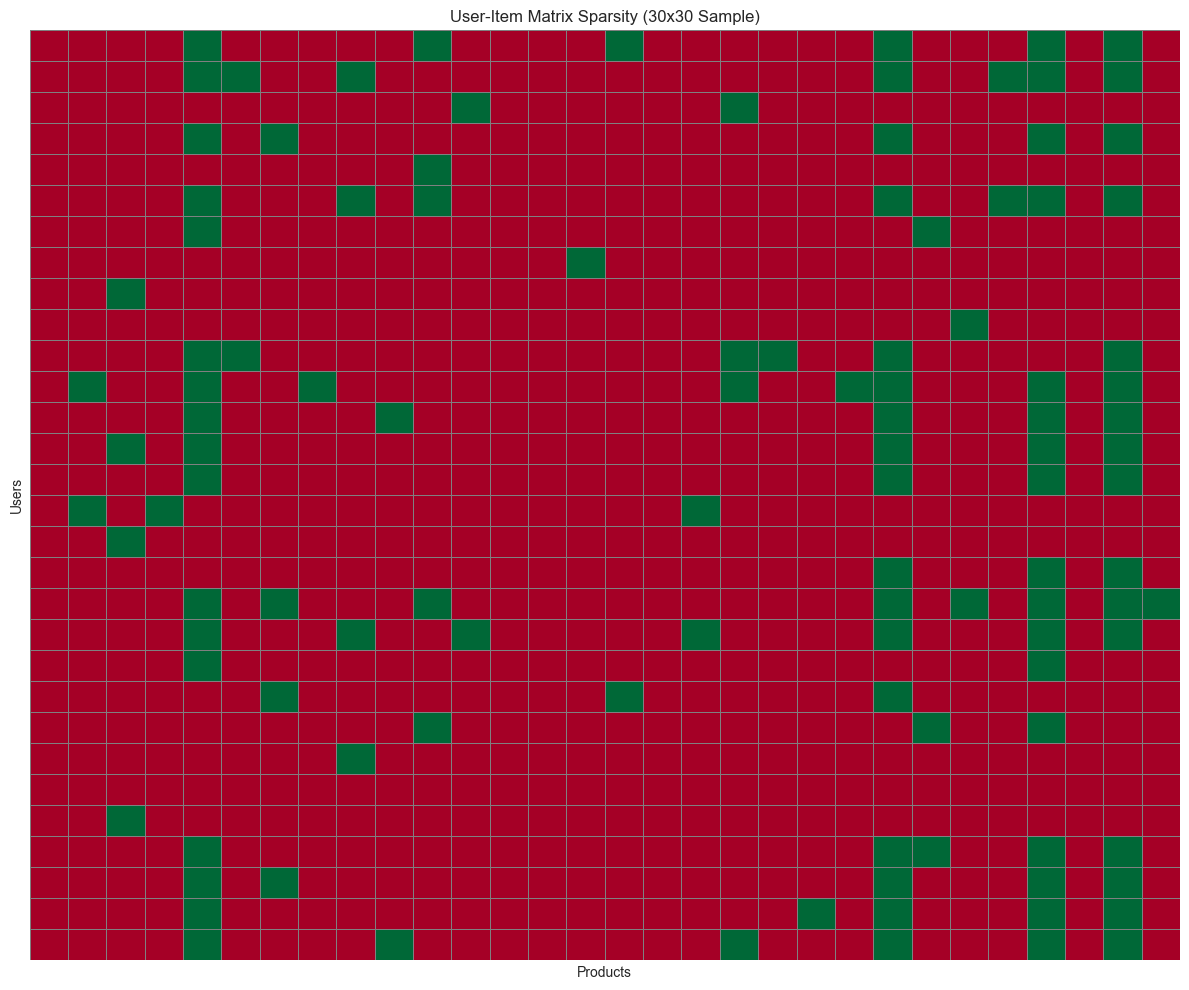

In [8]:
# Visualize matrix sparsity
sample_matrix = user_item_matrix.iloc[:30, :30]

plt.figure(figsize=(12, 10))
sns.heatmap(sample_matrix > 0, cmap='RdYlGn', cbar=False, 
            linewidths=0.5, linecolor='gray')
plt.title('User-Item Matrix Sparsity (30x30 Sample)')
plt.xlabel('Products')
plt.ylabel('Users')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

## Train Item-Based Collaborative Filtering

In [9]:
# Calculate item similarity matrix
item_similarity_matrix = cosine_similarity(user_item_matrix.T)

item_similarity_df = pd.DataFrame(
    item_similarity_matrix,
    index=user_item_matrix.columns,
    columns=user_item_matrix.columns
)

print(f"Similarity matrix: {item_similarity_df.shape}")
print(f"Average similarity: {item_similarity_matrix[np.triu_indices_from(item_similarity_matrix, k=1)].mean():.4f}")

Similarity matrix: (200, 200)
Average similarity: 0.1292


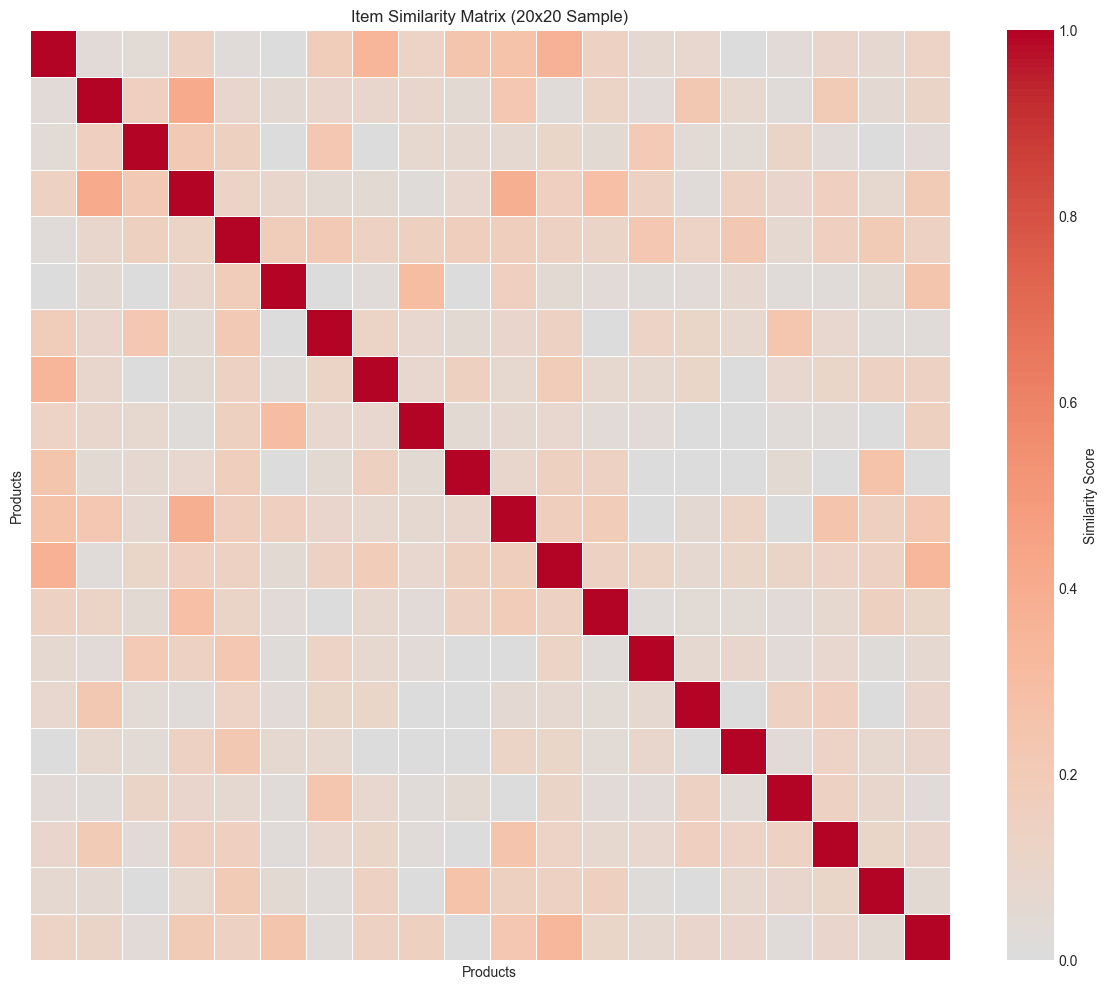

In [10]:
# Visualize similarity matrix
sample_sim = item_similarity_df.iloc[:20, :20]

plt.figure(figsize=(12, 10))
sns.heatmap(sample_sim, cmap='coolwarm', center=0, 
            vmin=0, vmax=1, linewidths=0.5, linecolor='white',
            cbar_kws={'label': 'Similarity Score'})
plt.title('Item Similarity Matrix (20x20 Sample)')
plt.xlabel('Products')
plt.ylabel('Products')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

## Generate Recommendations

In [11]:
def get_item_based_recommendations(user_id, top_n=10):
    if user_id not in user_item_matrix.index:
        return []
    
    user_interactions = user_item_matrix.loc[user_id]
    viewed_products = user_interactions[user_interactions > 0].index.tolist()
    
    if not viewed_products:
        return []
    
    scores = {}
    for product_id in user_item_matrix.columns:
        if product_id in viewed_products:
            continue
        
        score = 0
        total_weight = 0
        
        for viewed_product in viewed_products:
            similarity = item_similarity_df.loc[viewed_product, product_id]
            view_count = user_interactions[viewed_product]
            
            score += similarity * view_count
            total_weight += abs(similarity)
        
        if total_weight > 0:
            scores[product_id] = score / total_weight
    
    recommendations = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return recommendations

## Test with Sample User

In [12]:
# Sample user
sample_user = user_item_matrix.index[0]
recommendations = get_item_based_recommendations(sample_user, top_n=10)

# User viewing history
user_views = user_item_matrix.loc[sample_user]
viewed_products = user_views[user_views > 0].sort_values(ascending=False).head(5)

print("User Viewing History (Top 5):")
for i, (product_id, view_count) in enumerate(viewed_products.items(), 1):
    product_id_bytes = product_id if isinstance(product_id, bytes) else bytes.fromhex(product_id)
    product_name = df_products[df_products['product_id'] == product_id_bytes]['product_name'].values
    product_name = product_name[0] if len(product_name) > 0 else "Unknown"
    print(f"{i}. {product_name} ({int(view_count)} views)")

print("\nTop 10 Recommendations:")
for i, (product_id, score) in enumerate(recommendations, 1):
    product_id_bytes = product_id if isinstance(product_id, bytes) else bytes.fromhex(product_id)
    product_name = df_products[df_products['product_id'] == product_id_bytes]['product_name'].values
    product_name = product_name[0] if len(product_name) > 0 else "Unknown"
    print(f"{i}. {product_name} (score: {score:.4f})")

User Viewing History (Top 5):
1. NVIDIA GeForce RTX 4090 (16 views)
2. AMD Ryzen 9 7950X (15 views)
3. Logitech G Pro X Superlight (14 views)
4. LG UltraGear 27GN950-B (14 views)
5. Razer Blade 15 (14 views)

Top 10 Recommendations:
1. SteelSeries Rival 5 (score: 4.6474)
2. SteelSeries Arctis Nova Pro Wireless (score: 4.6322)
3. G.SKILL Trident Z5 RGB DDR5 (score: 4.6311)
4. Gigabyte B760M AORUS ELITE AX (score: 4.6287)
5. TeamGroup MP34 1TB NVMe (score: 4.6006)
6. Seagate Exos X18 16TB Enterprise HDD (score: 4.5660)
7. Seagate BarraCuda 2TB HDD (score: 4.4946)
8. Keychron Q1 (score: 4.4913)
9. Samsung 870 EVO 2TB SATA SSD (score: 4.4821)
10. be quiet! Straight Power 11 650W (score: 4.4756)


## Model Evaluation

In [13]:
def evaluate_recommendations(test_data, k=10):
    precision_scores = []
    recall_scores = []
    
    test_users = test_data['user_id'].unique()
    
    for user_id in test_users:
        actual_products = set(test_data[test_data['user_id'] == user_id]['product_id'].values)
        
        recs = get_item_based_recommendations(user_id, top_n=k)
        recommended_products = set([prod_id for prod_id, score in recs])
        
        if len(recommended_products) == 0 or len(actual_products) == 0:
            continue
        
        hits = len(recommended_products & actual_products)
        precision = hits / len(recommended_products) if len(recommended_products) > 0 else 0
        recall = hits / len(actual_products) if len(actual_products) > 0 else 0
        
        precision_scores.append(precision)
        recall_scores.append(recall)
    
    return np.mean(precision_scores), np.mean(recall_scores)

precision_10, recall_10 = evaluate_recommendations(test_data, k=10)
f1_score = 2 * (precision_10 * recall_10) / (precision_10 + recall_10) if (precision_10 + recall_10) > 0 else 0

print("Model Performance:")
print(f"Precision@10: {precision_10:.4f} ({precision_10*100:.2f}%)")
print(f"Recall@10: {recall_10:.4f} ({recall_10*100:.2f}%)")
print(f"F1-Score@10: {f1_score:.4f} ({f1_score*100:.2f}%)")

Model Performance:
Precision@10: 0.0916 (9.16%)
Recall@10: 0.1285 (12.85%)
F1-Score@10: 0.1069 (10.69%)


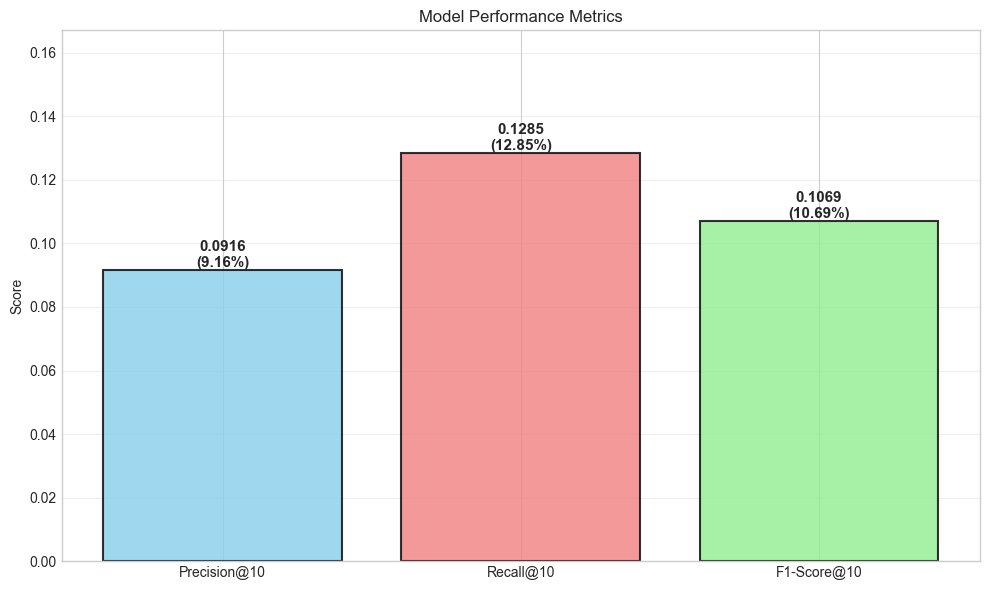

In [14]:
# Visualize performance
metrics = ['Precision@10', 'Recall@10', 'F1-Score@10']
values = [precision_10, recall_10, f1_score]
colors = ['skyblue', 'lightcoral', 'lightgreen']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics, values, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_ylim(0, max(values) * 1.3)
ax.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.4f}\n({value*100:.2f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Summary

- Algorithm: Item-Based Collaborative Filtering
- Similarity Metric: Cosine Similarity
- Training Data: 80% time-based split
- Matrix Size: 227 users x 200 products

In [15]:
# Export CF Model for Production
import pickle
import os
from datetime import datetime

print("Exporting CF model for production...")

# Create models directory
os.makedirs('../../ml-recommendation/models', exist_ok=True)

# Convert binary UUIDs to hex strings
def uuid_bytes_to_hex(uuid_bytes):
    """Convert UUID bytes to hex string uppercase"""
    if isinstance(uuid_bytes, bytes):
        return uuid_bytes.hex().upper()
    return str(uuid_bytes).replace('-', '').upper()

# Convert index and columns
item_similarity_hex = item_similarity_df.copy()
item_similarity_hex.index = [uuid_bytes_to_hex(x) for x in item_similarity_hex.index]
item_similarity_hex.columns = [uuid_bytes_to_hex(x) for x in item_similarity_hex.columns]

user_item_matrix_hex = user_item_matrix.copy()
user_item_matrix_hex.index = [uuid_bytes_to_hex(x) for x in user_item_matrix_hex.index]
user_item_matrix_hex.columns = [uuid_bytes_to_hex(x) for x in user_item_matrix_hex.columns]

# Export CF model with hex strings
cf_model_export = {
    "item_similarity": item_similarity_hex,
    "user_item_matrix": user_item_matrix_hex,
    "interaction_matrix": user_item_matrix_hex,  # Alias
    "product_ids": list(item_similarity_hex.columns),
    "metadata": {
        "training_date": datetime.now().isoformat(),
        "n_users": user_item_matrix_hex.shape[0],
        "n_products": user_item_matrix_hex.shape[1],
        "model_type": "item_based_cf"
    }
}

with open('../../ml-recommendation/models/cf_model.pkl', 'wb') as f:
    pickle.dump(cf_model_export, f)

print(f"✓ CF model exported to: ml-recommendation/models/cf_model.pkl")
print(f"  - Item similarity matrix: {item_similarity_hex.shape}")
print(f"  - Products: {len(cf_model_export['product_ids'])}")
print(f"  - Users: {user_item_matrix_hex.shape[0]}")
print(f"  - Sample product ID: {cf_model_export['product_ids'][0]}")


Exporting CF model for production...
✓ CF model exported to: ml-recommendation/models/cf_model.pkl
  - Item similarity matrix: (200, 200)
  - Products: 200
  - Users: 227
  - Sample product ID: 004D142E8D8E47C9B81E49168BD3F88B
